Enter # of neurons1000
Enter # of memory states25
Enter # of connected neighbours k150
Enter # of iterations each run2000
Enter # of runs to average over1000
Select memory state which when added noise gives initial state4


100%|██████████| 1000/1000 [134:12:14<00:00, 483.13s/it]      


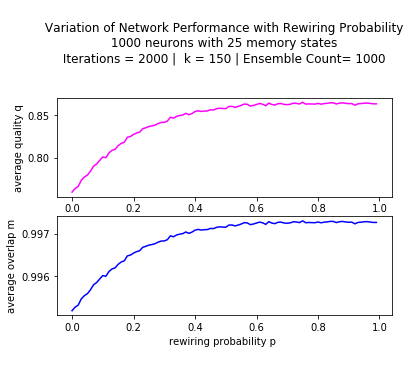

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: yash
"""
#change
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from random import choice
from matplotlib import cm
import datetime
from tqdm import tqdm
from random import randrange
import random

div = 100
n = int(input('Enter # of neurons'))
m = int(input('Enter # of memory states'))
flip = round(0.25 * n)

MemoryMatrix = np.zeros((m, n))

for a in range(0, m):
    mem = []
    for i in range(0, n):
        x = choice([1, -1])
        mem.append(x)

    MemoryMatrix[a] = mem
    x = 0

k = int(input('Enter # of connected neighbours k'))
n_i = int(input('Enter # of iterations each run'))
ensembleCount = int(input('Enter # of runs to average over'))
target = int(input('Select memory state which when added noise gives initial state'))


suffix = datetime.datetime.now().strftime("%m%d_%H%M%S")
filename = "_".join([str(n), str(m), str(k), str(n_i), str(ensembleCount), suffix])
np.savetxt(filename + "-ms-r.csv", np.column_stack((np.transpose(MemoryMatrix))), delimiter=",", fmt='%s')

OverlapMatrixn = np.zeros((ensembleCount, div))  # initiate overlap matrix
EtaMatrixn = np.zeros((ensembleCount, div))  # initiate quality matrix

for b in tqdm(range(ensembleCount)):
    u = []
    u = MemoryMatrix[target].copy()  # copy M2 to initial state
    hammingtemp = overlaptemp = 0
    hammingavg = overlapavg = 0
    Y = []
    Y2 = []
    X = []
    p = 0

    rs = random.sample(range(0,n), flip)

    for p in list(rs): #randomly pick up 25 percent and flip them
        u[p] = (MemoryMatrix[target][p] * -1)


    for rho in (range(0, 100)):  # for this given random matrix, loop over different p values

        p = (rho / div)
        hammingtemp = overlaptemp = 0
        hammingval = overlapval = 0
        q = 0

        g = nx.watts_strogatz_graph(n, k, p)

        # g.pos = {}
        # for x in range(4):
        #      for y in range(4):
        #         g.pos[y * 4 + x] = (x, -y)

        # set the initial state
        st = 0
        for st in range(0, n):
            g.nodes[st]['state'] = u[st]

        # nx.draw(g, pos = g.pos, cmap = cm.jet, vmin = -1, vmax = 1, node_color = [g.nodes[i]['state'] for i in
        # g.nodes]) plt.show() print ("Initial Graph")

        # train the network
        for i, j in g.edges:
            weight = 0
            alpha = 0
            for alpha in range(0, m):
                weight = weight + (MemoryMatrix[alpha][i] * MemoryMatrix[alpha][j])
            g.edges[i, j]['weight'] = (weight / n)

        # evolve according to hopfield dynamics, n_i iterations
        z = 0
        for z in range(1, (n_i + 1)):
            i = choice(list(g.nodes))
            s = sum([g.edges[i, j]['weight'] * g.nodes[j]['state'] for j in g.neighbors(i)])
            g.nodes[i]['state'] = 1 if s > 0 else -1 if s < 0 else g.nodes[i]['state']

            # nx.draw(g, pos = g.pos, cmap = cm.jet, vmin = -1, vmax = 1, node_color = [g.nodes[i]['state'] for i in
            # g.nodes]) plt.show()
            z = z + 1

        # calculate hamming distances and overlap for all the memory states

        for i in list(g.nodes):
            overlaptemp += (MemoryMatrix[target][i] * g.nodes[i]['state'])
            hammingtemp += abs(g.nodes[i]['state'] - MemoryMatrix[target][i])

        hammingval = (hammingtemp / (m * 2))
        overlapval = (overlaptemp / n)
        q = ((n - hammingval) / n)
        X.append(p)
        Y.append(q)
        Y2.append(overlapval)


    OverlapMatrixn[b] = Y2
    EtaMatrixn[b] = Y

    b = b + 1

col_totalsE = np.sum(OverlapMatrixn, 0)
col_totalsO = np.sum(EtaMatrixn, 0)

col_totalsEavg = [(x / ensembleCount) for x in col_totalsE]
col_totalsOavg = [(x / ensembleCount) for x in col_totalsO]

# set up figure and axes
plt.subplot(2, 1, 1)
plt.plot(X, col_totalsEavg, color="magenta")
plt.title("\n Variation of Network Performance with Rewiring Probability \n %s neurons with %s memory states \n "
          "Iterations = %s |  k = %s | Ensemble Count= ""%s \n \n" % (n, m, n_i, k, ensembleCount))
plt.ylabel("average quality q")

plt.subplot(2, 1, 2)
plt.ylabel("average overlap m")
plt.xlabel("rewiring probability p \n")
plt.plot(X, col_totalsOavg, color="blue")

suffix = datetime.datetime.now().strftime("%m%d_%H%M%S")
filename = "_".join([str(n), str(m), str(k), str(n_i), str(ensembleCount), suffix])
plt.autoscale()
plt.savefig(filename, dpi=200, bbox_inches = "tight")
plt.show()

np.savetxt(filename + "-r-Q.csv", np.column_stack((X, col_totalsEavg)), delimiter=",", fmt='%s')
np.savetxt(filename + "-r-O.csv", np.column_stack((X, col_totalsOavg)), delimiter=",", fmt='%s')

